In [10]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings

# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [11]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    'data/filtered_gene_bc_matrices/hg19',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('../write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


/Users/mehakrafiq/miniconda3/envs/scVAE/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/mehakrafiq/miniconda3/envs/scVAE/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


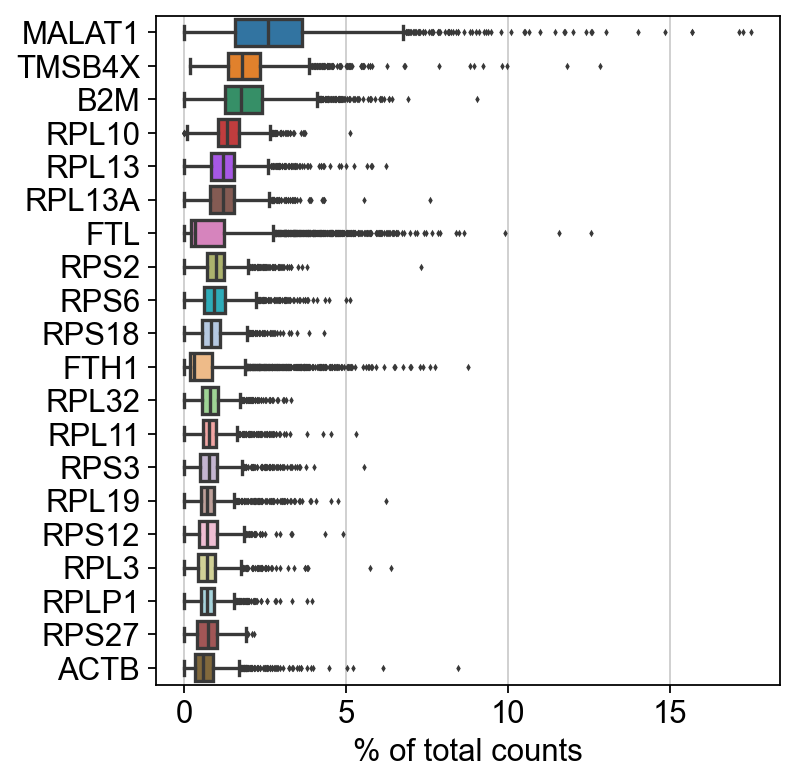

In [12]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [13]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


/Users/mehakrafiq/miniconda3/envs/scVAE/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mehakrafiq/miniconda3/envs/scVAE/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mehakrafiq/miniconda3/envs/scVAE/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mehakrafiq/miniconda3/envs/scVAE/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

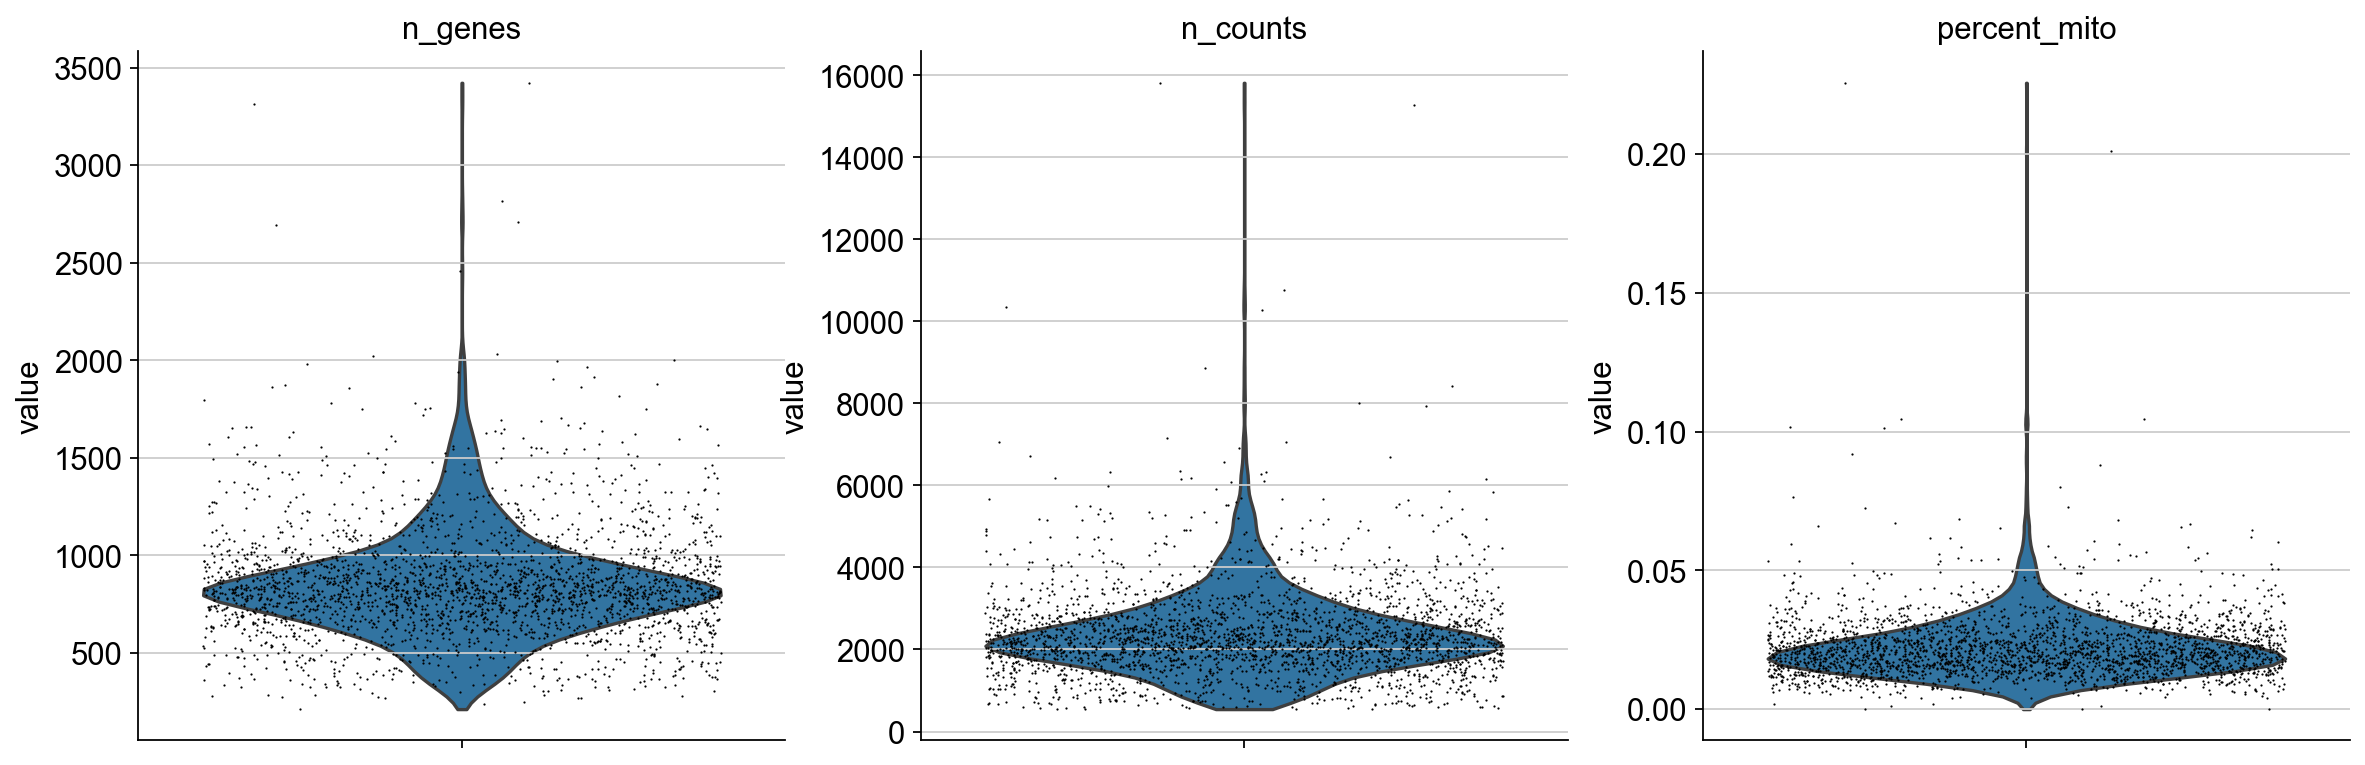

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [14]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [15]:
adata.layers["counts"] = adata.X.copy() # preserve counts
adata.X = adata.layers["counts"].copy() # use counts for normalization and dimensionality reduction
adata

/var/folders/zy/fbwt9jj16vg4gzyd8mdl2mrm0000gn/T/ipykernel_3752/2399221497.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy() # preserve counts


AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'
    layers: 'counts'

In [16]:
# Store the raw data
adata.raw = adata

In [17]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    subset=True,
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [18]:
adata

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    layers: 'counts'

## Dimension Reduction

### DCA

In [19]:
from dca.api import dca



ImportError: cannot import name 'l1_l2' from 'keras.regularizers' (/Users/mehakrafiq/miniconda3/envs/scVAE/lib/python3.9/site-packages/keras/regularizers/__init__.py)

In [20]:
# Apply DCA
adata = dca(adata, hidden_size=[128, 10], return_info=True, verbose=True)


NameError: name 'dca' is not defined

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


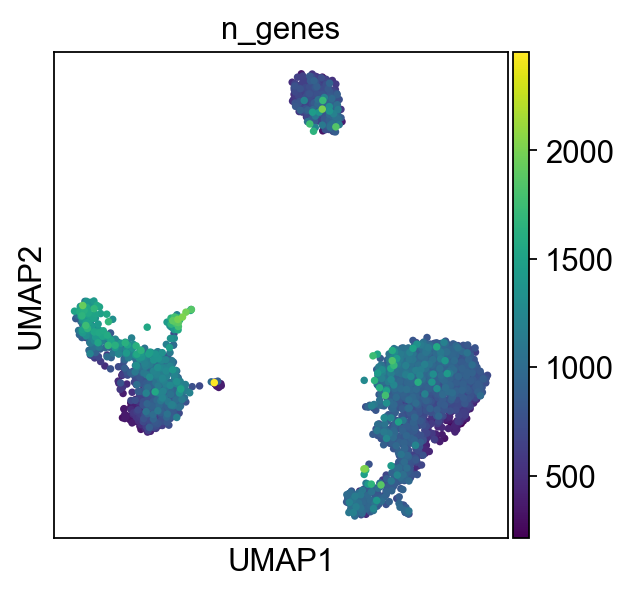

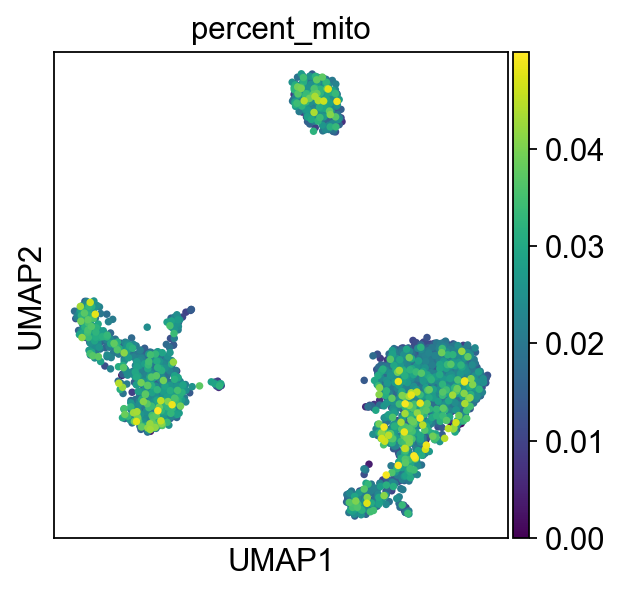

In [110]:
# Plot the results
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)





In [ ]:
# Save the data
adata.write('../write/pbmc3k_dca.h5ad', compression='gzip')

In [ ]:
adata

In [ ]:
# Extract the latent space representation
latent_representation = adata.obsm['X_dca']

# Convert latent representation to a DataFrame
latent_df = pd.DataFrame(latent_representation, index=adata.obs_names, columns=[f'latent_dim{i+1}' for i in range(10)])

# Save to CSV file
latent_df.to_csv('dca_latent_representation.csv')